In this notebook, we analyze log data with a time range of about 1 week (aggregated by an interval of 1 minute).
- Data are imported from BigQuery, with Reaggerate the data/features by an interval of 5 minutes.
- For query count (feature) of a selected service, an Autoencoder model are is trained.
- The trained model is deployed to AI Platform.
- The deployed model is utilized to make predictions for fake data with custom patterns.

### Setup environment

In [20]:
# !pip install --upgrade google-cloud-bigquery[pandas]
%load_ext google.cloud.bigquery
from google.cloud import bigquery
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from matplotlib.colors import LogNorm
from sklearn import mixture

import itertools
import tensorflow as tf
import json
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import LocalOutlierFactor

from sklearn.cluster import DBSCAN
from sklearn import metrics

import time
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs

from sklearn.linear_model import LinearRegression

import sklearn.gaussian_process as gp

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches

client = bigquery.Client()
sns.set(style="white")

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


### Import data

In [67]:
sql = """
SELECT
    *
FROM
    `YOUR-PROJECT-ID.dataflow_log_analytics.timestamp_entity_field_table_1w_ti1m`
WHERE 
    entityName <> ''
"""

In [5]:
t0 = time.time()
df = client.query(sql).to_dataframe()
t1 = time.time()
print("Loading data took {:.2} s".format(t1 - t0))

Loading data took 9.5e+02 s


In [6]:
t0 = time.time()
df.to_csv('./data/tef_1w_ti1m.csv')
t1 = time.time()
print("Export pd to csv took {:.2} s".format(t1 - t0))

Export pd to csv took 6.4e+01 s


In [7]:
df.head()

,seconds,entityType,entityName,fieldName,fieldValue
0,1597869360,service_,preprod-translate.sandbox.googleapis.com,check_,0.0
1,1597386420,service_,dev-contactcenterconfiguration-pa.sandbox.goog...,check_,141.0
2,1597821180,service_,test-hr.corp.googleapis.com,check_,1176.0
3,1597495500,service_,int-3-sqladmin.sandbox.googleapis.com,check_,0.0
4,1597549680,service_,daily6-notebook-pa.sandbox.googleapis.com,check_,9.0


Here are the meaning for field names (fieldName):
- 'check_': check error count
- 'query_': query count
- 'quota_': quota error count
- 'status': status error count

In [8]:
df['seconds'] = df['seconds'].astype(float)
df['fieldValue'] = df['fieldValue'].astype(float)
df.describe()

,seconds,fieldValue
count,2.091180e+07,2.091180e+07
mean,1.597597e+09,1.238496e+03
std,1.706444e+05,1.355216e+04
min,1.597302e+09,0.000000e+00
25%,1.597447e+09,0.000000e+00
50%,1.597600e+09,4.000000e+00
75%,1.597749e+09,7.000000e+01
max,1.597884e+09,5.969420e+05


In [9]:
dfs = df[df.entityType == 'service_']
dfs.head()

,seconds,entityType,entityName,fieldName,fieldValue
0,1.597869e+09,service_,preprod-translate.sandbox.googleapis.com,check_,0.0
1,1.597386e+09,service_,dev-contactcenterconfiguration-pa.sandbox.goog...,check_,141.0
2,1.597821e+09,service_,test-hr.corp.googleapis.com,check_,1176.0
3,1.597496e+09,service_,int-3-sqladmin.sandbox.googleapis.com,check_,0.0
4,1.597550e+09,service_,daily6-notebook-pa.sandbox.googleapis.com,check_,9.0


In [10]:
fields = dfs.fieldName.unique()
field_count = len(fields)

In [11]:
map_field_idx = {}
for idx, field in enumerate(fields):
    map_field_idx[field] = idx
assert(len(map_field_idx) == field_count)
print(map_field_idx)

{'check_': 0, 'query_': 1, 'quota_': 2, 'status': 3}


In [12]:
services = dfs.entityName.unique()
service_count = len(services)

In [14]:
map_service_idx = {}
for idx, service in enumerate(services):
    map_service_idx[service] = idx
assert(len(map_service_idx) == service_count)

There are some services with interesting patterns. Here are a part of them:

In [18]:
print(map_service_idx['autopush-healthcare.sandbox.googleapis.com'])
print(map_service_idx['staging-hr.corp.googleapis.com'])
print(map_service_idx['beta-tasks-pa.sandbox.googleapis.com'])
print(map_service_idx['realtimesupport-staging.sandbox.googleapis.com'])
print(map_service_idx['test-stackdriver.sandbox.googleapis.com'])
print(map_service_idx['staging-dataflowbackend-pa.sandbox.googleapis.com'])

21
243
9
193
336
153


In [23]:
#
interval = 60 * 5 # in second
count_assert = 60 * 24 * 7 // 5
#
time_min, time_max = dfs.seconds.min(), dfs.seconds.max()

# convert 'seconds' column to the index of corresponding interval
def to_interval_index(time):
    return math.floor((time - time_min) / interval)

assert(to_interval_index(time_min) == 0)

inteval_index_max = to_interval_index(time_max)
interval_count = inteval_index_max + 1
print(interval_count)
# assert(interval_count == count_assert)

1940


Field values (e.g., query count, check error count) for a service within the same interval are accumulated. 

In [25]:
arrs = np.zeros((service_count, interval_count, field_count))
print(arrs.shape)

t0 = time.time()

for idx, row in dfs.iterrows():
    if (idx % 1e6 == 0): print(idx)
        
    seconds = row['seconds']
    service = row['entityName']
    field   = row['fieldName']
    val     = row['fieldValue']

    interval_idx = to_interval_index(seconds)
    service_idx  = map_service_idx[service]
    field_idx    = map_field_idx[field]
    
    arrs[service_idx, interval_idx, field_idx] += val
    
t1 = time.time()
print("Write np array took {:.2} s".format(t1 - t0))

np.save('./data/1w_ti5m.npy', arrs)
# arrs = np.load('./data/1w_ti5m.npy')

(705, 1940, 4)
0
1000000
2000000
4000000
6000000
8000000
10000000
12000000
17000000
18000000
19000000
20000000
Write np array took 1.1e+03 s


### Visualize data

In [27]:
#
TIME_STEPS = 60 * 24 // 5
windows = arrs.shape[1] // TIME_STEPS + (0 if arrs.shape[1] % TIME_STEPS == 0 else 1)

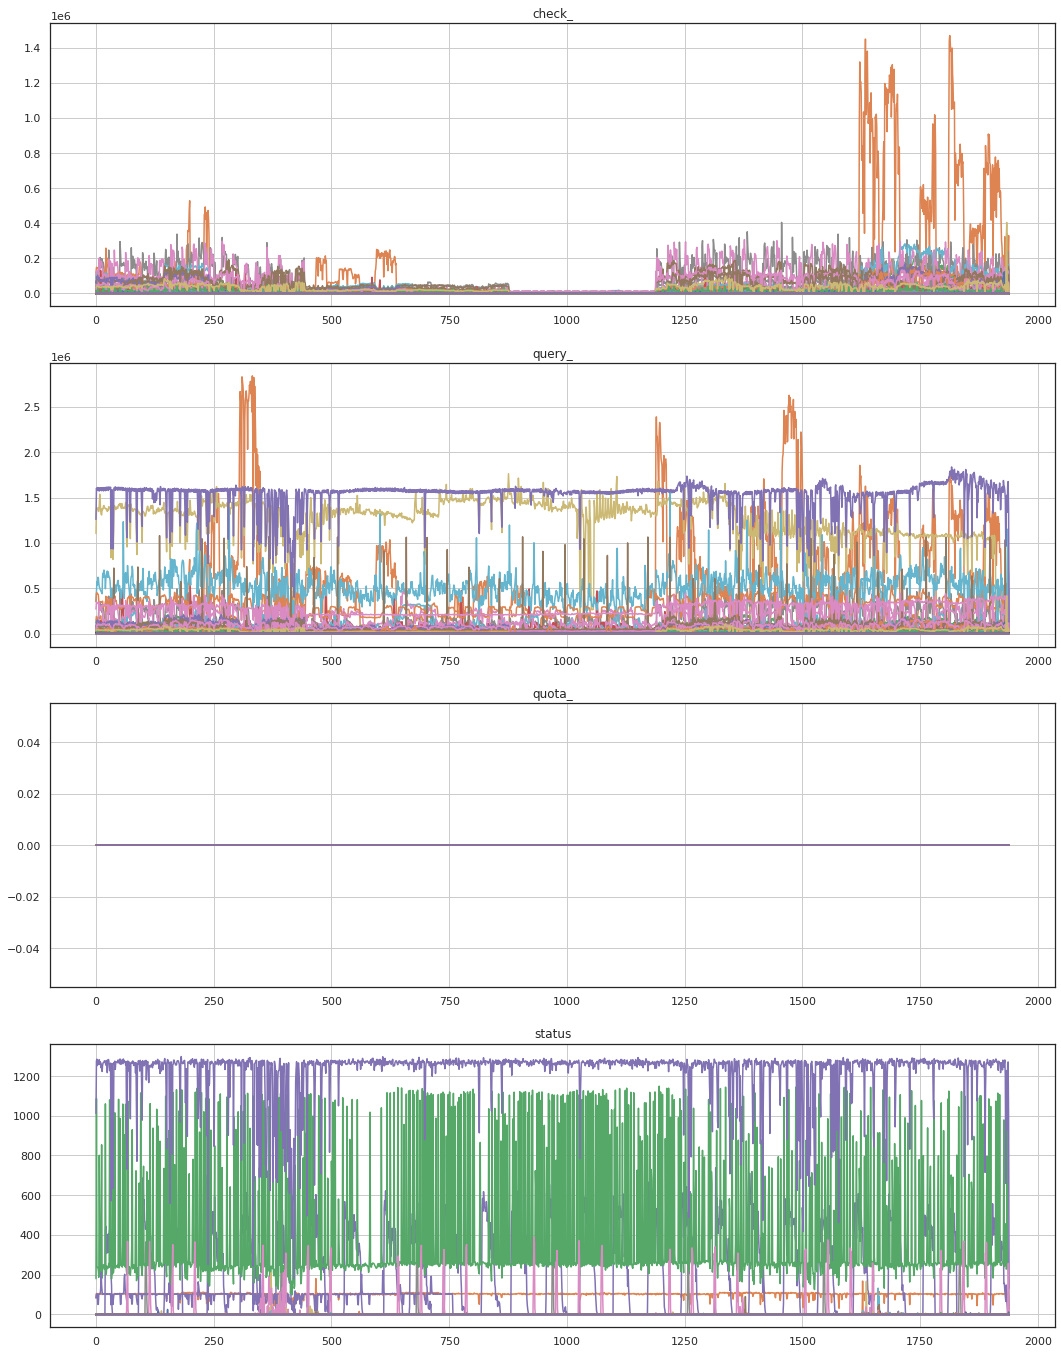

In [28]:
fig, axs = plt.subplots(4, 1, figsize=(18, 24))
for i in range(4):
    r, c = i // 1, i % 1
    for service_index in range(service_count):
        axs[r].plot(arrs[service_index,:,i])
    axs[r].set_title(fields[i])
    axs[r].grid()
plt.show()

### Train Autoencoder

For successful deployment, please make sure the version of TensorFlow is compatible with runtime versions AI Platform Prediction: https://cloud.google.com/ai-platform/prediction/docs/runtime-version-list

In [62]:
# tf.keras.layers.Conv1DTranspose
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1DTranspose
# !pip install --upgrade tensorflow-gpu
!pip uninstall tensorflow-gpu -y
!pip install tensorflow-gpu==2.2.0
!pip uninstall keras -y
!pip install keras==2.3.1

# !pip install --upgrade google-api-python-client

Found existing installation: tensorflow-gpu 2.2.0
Uninstalling tensorflow-gpu-2.2.0:
  Successfully uninstalled tensorflow-gpu-2.2.0
  Using cached tensorflow_gpu-2.2.0-cp37-cp37m-manylinux2010_x86_64.whl (516.2 MB)
Found existing installation: Keras 2.3.1
Uninstalling Keras-2.3.1:
  Successfully uninstalled Keras-2.3.1
  Using cached Keras-2.3.1-py2.py3-none-any.whl (377 kB)


In [30]:
import tensorflow as tf
print(tf.version.VERSION)

2.2.0


In [31]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md
from mpl_toolkits.mplot3d import Axes3D
import time

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

from sklearn.preprocessing import StandardScaler

from statistics import mean 

import pickle

from preprocess import MySimpleScaler #

import googleapiclient.discovery

import h5py

import functools

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 11, 5

In [34]:
checks   = arrs[:,:,0].tolist()
queries  = arrs[:,:,1].tolist()
# quotas   = arrs[:,:,2].tolist()
statuses = arrs[:,:,3].tolist()

service_count = len(queries)

In [35]:
def normalize(values):
#     mean = np.mean(values)
#     values -= mean
#     std = np.std(values)
#     values /= std
#     return values, mean, std
    vmin = np.min(values)
    vmax = np.max(values)
    values = (values - vmin) / (vmax - vmin)
    return values, _, _

Query count for a specific service is normalized as pre-processing. 

In [63]:
qs            = [[]] * service_count
qs_normalized = [[]] * service_count

for i in range(service_count):
    v, _, _ = normalize(queries[i])
    
    qs[i]            = np.append(queries[i], [0.0] * (4 - len(v) % 4)) 
    qs_normalized[i] = np.append(v,          [0.0] * (4 - len(v) % 4)) 
    
qs            = np.array(qs)
qs_normalized = np.array(qs_normalized)

print(qs.shape)
print(qs.shape == qs_normalized.shape)

(705, 1944)
True


In [64]:
train_mae_loss_list = [[]] * service_count
test_mae_loss_list  = [[]] * service_count

The chosen time step (TIME_STEPS) is 12, meaning a time window of 12 * 5 = 60 minutes.   
The chosen slide step (SLIDE_STEPS) is 1, meaning a sample comes 1 step later than its previous sample (12 - 1 = 11 steps are overlapped). 

In [65]:
TIME_STEPS = 12
SLIDE_STEPS = 1

train_test_split=0.85
train_size = int(qs_normalized.shape[1] * train_test_split)

n_covers = qs_normalized.shape[1] - 1 # strange

In [39]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = list(X[i:(i + time_steps)])
        Xs.append(v)        
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [44]:
def dl(idx, train_test_split, TIME_STEPS):
    # https://github.com/curiousily/Deep-Learning-For-Hackers/blob/master/14.time-series-anomaly-detection.ipynb
    data = qs_normalized[idx].reshape(-1,1)

    train_size = int(data.shape[0] * train_test_split)

    train_range = range(0, train_size)
    test_range  = range(0, data.shape[0]) #range(train_size, data.shape[0])
    train = data[train_range]
    test  = data[test_range]
    
    # reshape to [samples, time_steps, n_features]
    X_train, y_train = create_dataset(train, train, TIME_STEPS)
    X_test,  y_test  = create_dataset(test,  test,  TIME_STEPS)
    
    #
    model = keras.Sequential()
    model.add(keras.layers.LSTM(
        units=64, 
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
    model.add(keras.layers.LSTM(units=64, return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
    model.compile(loss='mae', optimizer='adam')
    
    model.summary()
    
    history = model.fit(
        X_train,
        X_train,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        verbose=0,
        # callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")],
    )
    
    #
    X_train_pred = model.predict(X_train)
    train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
    train_mae_loss_list[idx] = train_mae_loss #
    
    X_test_pred = model.predict(X_test)
    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
    test_mae_loss_list[idx] = test_mae_loss #
    
    #
    xtrp = X_train_pred[:,-1,0].reshape(-1,1)
    xtep = X_test_pred[:,-1,0].reshape(-1,1)
    
    #
    f, axes = plt.subplots(1, 3, figsize=(22, 5), sharex=False)
    
    axes[0].plot(history.history['loss'], label='train')
    axes[0].plot(history.history['val_loss'], label='validation')
    axes[0].legend()
    
    sns.distplot(train_mae_loss, bins=50, kde=True, ax=axes[1]).set_title('train mae loss')
    
    sns.distplot(test_mae_loss, bins=50, kde=True, ax=axes[2]).set_title('test mae loss')
    
    f_, axes_ = plt.subplots(figsize=(22, 5), sharex=False)
    
    # plt.plot(train_range, train, 'b', label='train')
    plt.plot(test_range,  test,  label='test')
    # plt.plot(train_range[TIME_STEPS-1:-1], xtrp, 'b--')
    plt.plot(test_range[TIME_STEPS-1:-1],  xtep, label='test pred')
    # plt.plot(train_range[TIME_STEPS-1:-1], xtrp - train[TIME_STEPS-1:-1], 'bx', label='train pred error')
    plt.scatter(test_range[TIME_STEPS-1:-1],  xtep - test[TIME_STEPS-1:-1],  c=xtep - test[TIME_STEPS-1:-1], label='test pred error')
    plt.legend()
    
    plt.ylim(-1., 1.)
    
    plt.title('idx: {}'.format(idx))
    plt.show()
    
    return model, X_test, X_test_pred

In [45]:
def post_avg(idx, ori, test_pred): 
    ori = ori.reshape(-1)

    lss        = [[] for _ in range(n_covers)]
    pred_avgs  = [[] for _ in range(n_covers)]

    d = test_pred
    for i0 in range(len(d)):
        for i1 in range(len(d[0])):
            lss[i0 + (SLIDE_STEPS - 1) + i1].append(d[i0][i1])

    for i, ls in enumerate(lss):
        # if i % 100 == 0: print(i, ls)
        pred_avgs[i] = mean(ls)

    test_pred_avg = list(pred_avgs)

    s = 0
    for i in range(train_size, n_covers):
        s += abs(pred_avgs[i] - ori[i]) # absolute val
    errs_no_train = s / (n_covers - train_size) 
    
    return test_pred_avg, errs_no_train

In [46]:
idx = 21 # 'autopush-healthcare.sandbox.googleapis.com'

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 12, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 64)            33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 64)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 12, 1)             65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
____________________________________________________

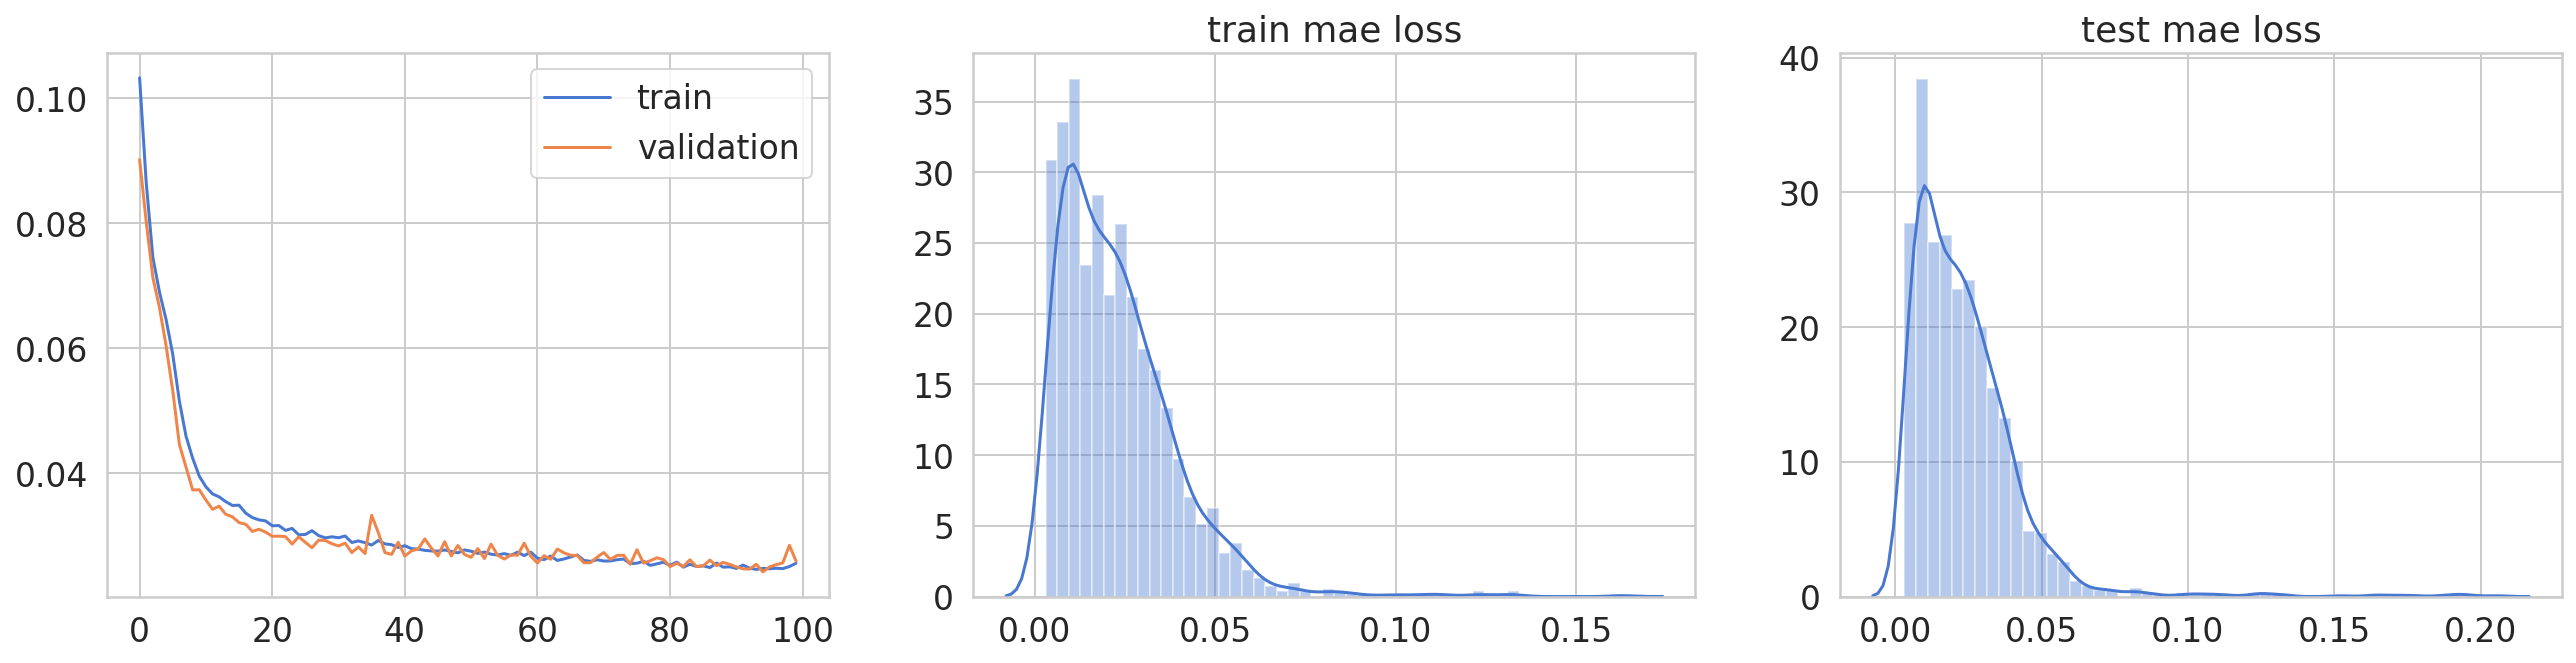

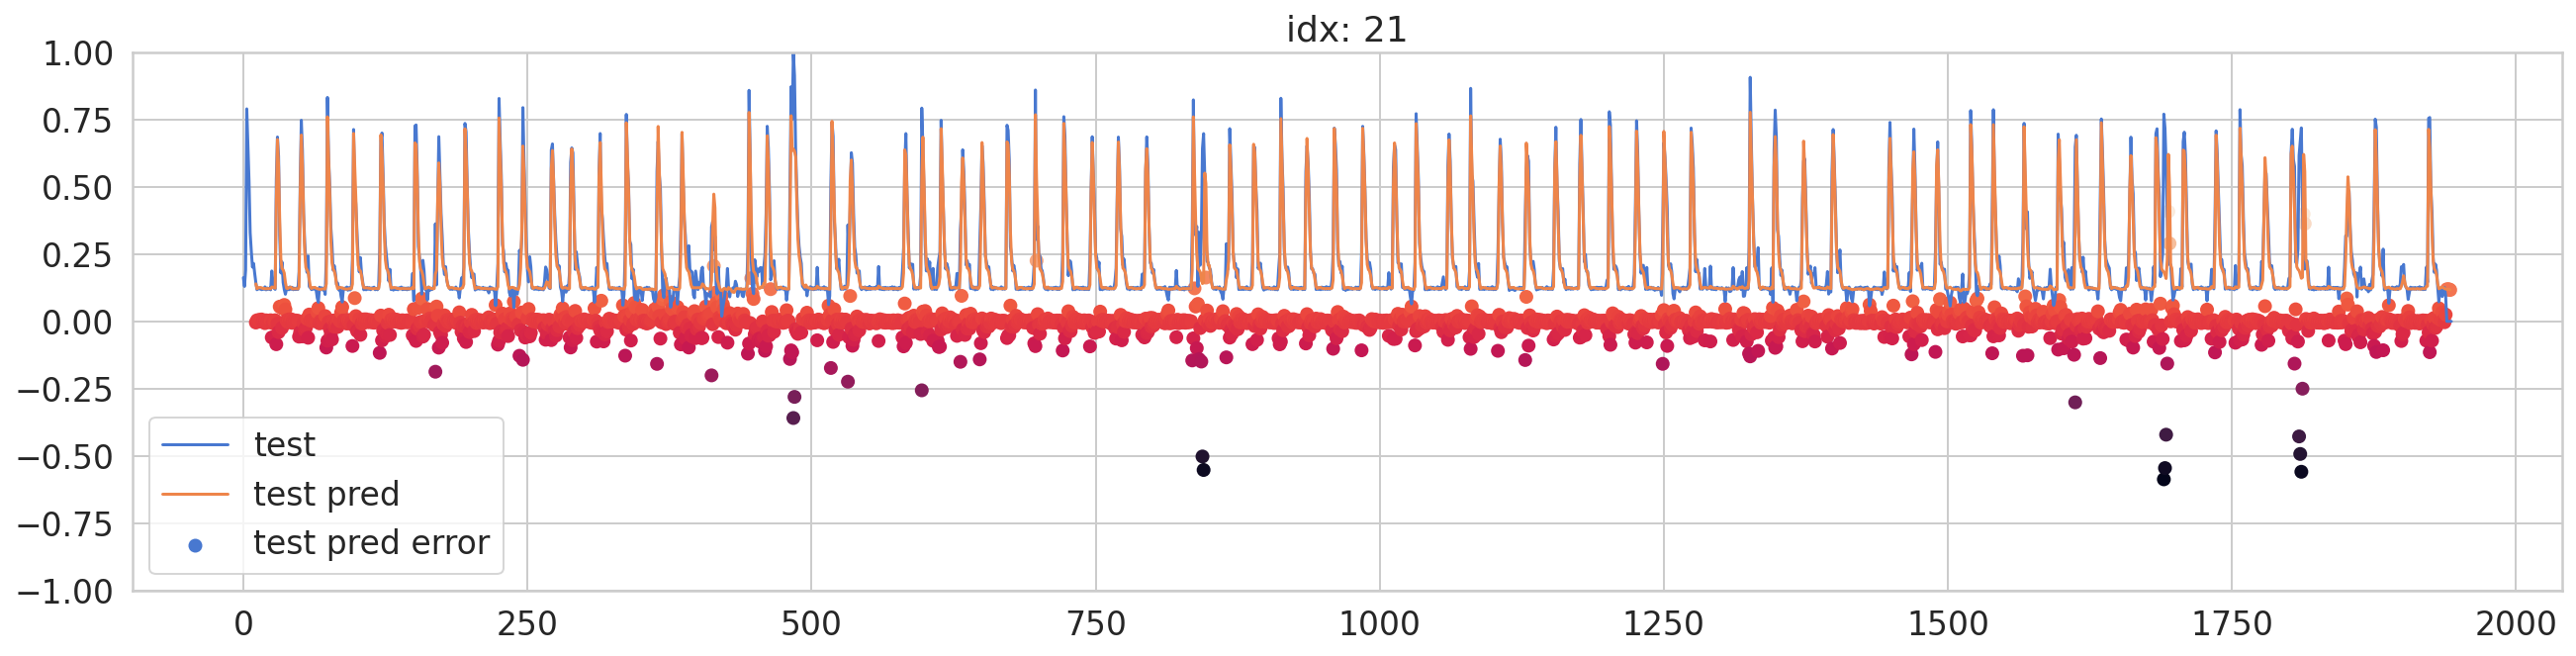

In [47]:
model, X_test, X_test_pred = dl(idx=idx, train_test_split=train_test_split, TIME_STEPS=TIME_STEPS)

### Deploy the model

In [66]:
PROJECT_ID  = 'YOUR-PROJECT-ID'
BUCKET_NAME = 'autoencoder_keras'

In [52]:
MODEL_NAME = 'KerasAutoencoder'
VERSION_NAME = 'v0'

In [50]:
! gcloud ai-platform models create $MODEL_NAME 

Using endpoint [https://ml.googleapis.com/]

Learn more about regional endpoints and see a list of available regions: https://cloud.google.com/ai-platform/prediction/docs/regional-endpoints
ERROR: (gcloud.ai-platform.models.create) Resource in project [shuainie-project1] is the subject of a conflict: Field: model.name Error: A model with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A model with the same name already exists.
    field: model.name


In [51]:
model.save('gs://' + BUCKET_NAME + '/saved_model/model/', save_format = 'tf')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: gs://autoencoder_keras/saved_model/model/assets


In [53]:
! gcloud --quiet beta ai-platform versions create $VERSION_NAME \
  --model $MODEL_NAME \
  --runtime-version 2.2 \
  --python-version 3.7 \
  --origin gs://$BUCKET_NAME/saved_model/model/ \
  --framework tensorflow \
  --verbosity debug

DEBUG: Running [gcloud.beta.ai-platform.versions.create] with arguments: [--framework: "tensorflow", --model: "KerasAutoencoder", --origin: "gs://autoencoder_keras/saved_model/model/", --python-version: "3.7", --quiet: "True", --runtime-version: "2.2", --verbosity: "debug", VERSION: "v0"]
Using endpoint [https://ml.googleapis.com/]
Creating version (this might take a few minutes)......done.                    
INFO: Display format: "none"
DEBUG: SDK update checks are disabled.


In [54]:
! gcloud beta ai-platform versions describe $VERSION_NAME --model=$MODEL_NAME

Using endpoint [https://ml.googleapis.com/]
createTime: '2020-09-22T02:28:14Z'
deploymentUri: gs://autoencoder_keras/saved_model/model/
etag: QxWgf_eXSZw=
framework: TENSORFLOW
machineType: mls1-c1-m2
name: projects/shuainie-project1/models/KerasAutoencoder/versions/v0
pythonVersion: '3.7'
runtimeVersion: '2.2'
state: READY


### Make predictions with the deployed model

In [59]:
def make_prediction(data=qs_normalized[idx].reshape(-1,1), title=''):
    t0 = time.time()
    
    # pre-processing
    train_size = int(data.shape[0] * train_test_split)
    test_range  = range(0, data.shape[0]) #range(train_size, data.shape[0])
    test  = data[test_range]
    X_test, _ = create_dataset(test, test, TIME_STEPS)

    instances = X_test.tolist()

    # predict API
    service = googleapiclient.discovery.build('ml', 'v1')
    name = 'projects/{}/models/{}/versions/{}'.format(PROJECT_ID, MODEL_NAME, VERSION_NAME)

    response = service.projects().predict(
        name=name,
        body={'instances': instances}
    ).execute()

    if 'error' in response:
        raise RuntimeError(response['error'])

    # post-processing
    test_pred = []
    for td in response['predictions']:
        it = functools.reduce(lambda a, b: a+b, td['time_distributed'])
        test_pred.append(it)

    assert(len(instances) == len(test_pred))

    test_pred_avg, errs_no_train = post_avg(idx, data, test_pred)

    '''
    f_, axes_ = plt.subplots(figsize=(11, 5), sharex=False)
    plt.plot(range(train_size, n_covers), data[train_size:-1], label='observed')
    plt.plot(range(train_size, n_covers), test_pred_avg[train_size:], label='predicted')
    err = data[train_size:-1] - np.array(test_pred_avg[train_size:]).reshape(-1,1)
    plt.scatter(range(train_size, n_covers),   err,  c=err, label='pred error')
    plt.legend()
    #plt.axvline(x=train_size, color='r')
    plt.ylim(-1., 1.5)
    plt.title(title + ', avg test mae: {:.3}'.format(errs_no_train))
    plt.xlabel('(5 min) time interval')
    plt.ylabel('normalized query count')
    '''
    f_, axes_ = plt.subplots(figsize=(22, 5), sharex=False)
    plt.plot(data[:-1], label='observed')
    plt.plot(test_pred_avg, label='predicted')
    err = data[:-1] - np.array(test_pred_avg).reshape(-1,1)
    plt.scatter(range(err.shape[0]),  err,  c=err, label='pred error')
    plt.legend()
    plt.axvline(x=train_size, color='r')
    plt.ylim(-1., 1.)
    plt.title(title + ', avg test mae: {:.3}'.format(errs_no_train))
    plt.xlabel('(5 min) time interval')
    plt.ylabel('normalized query count')
    
    t1 = time.time()
    print('Elapsed time is {:.2} sec'.format(t1 - t0))

In [57]:
# idx 23
d = np.copy(qs_normalized[idx].reshape(-1,1))

# 1) peak twice as high
d1 = np.copy(d)

for i, q in enumerate(d1):
    if i > train_size:
        d1[i] = 2 * q
        
# 2) peak is half
d2 = np.copy(d)

for i, q in enumerate(d2):
    if i > train_size:
        d2[i] = 1/2 * q
        
# 3) peak is twice as dense
d3 = np.copy(d)

for i, q in enumerate(d3):
    if i > train_size:
        ni = ((i - train_size) * 2) % (d3.shape[0] - train_size) + train_size
        d3[i] = d[ni]
        
# 4) peak offset (by 64)
d4 = np.copy(d)

for i, q in enumerate(d4):
    if i > train_size:
        ni = ((i - train_size) + 64) % (d4.shape[0] - train_size) + train_size
        d4[i] = d[ni]

Elapsed time is 0.97 sec
Elapsed time is 1.4 sec
Elapsed time is 0.91 sec
Elapsed time is 0.86 sec
Elapsed time is 0.8 sec


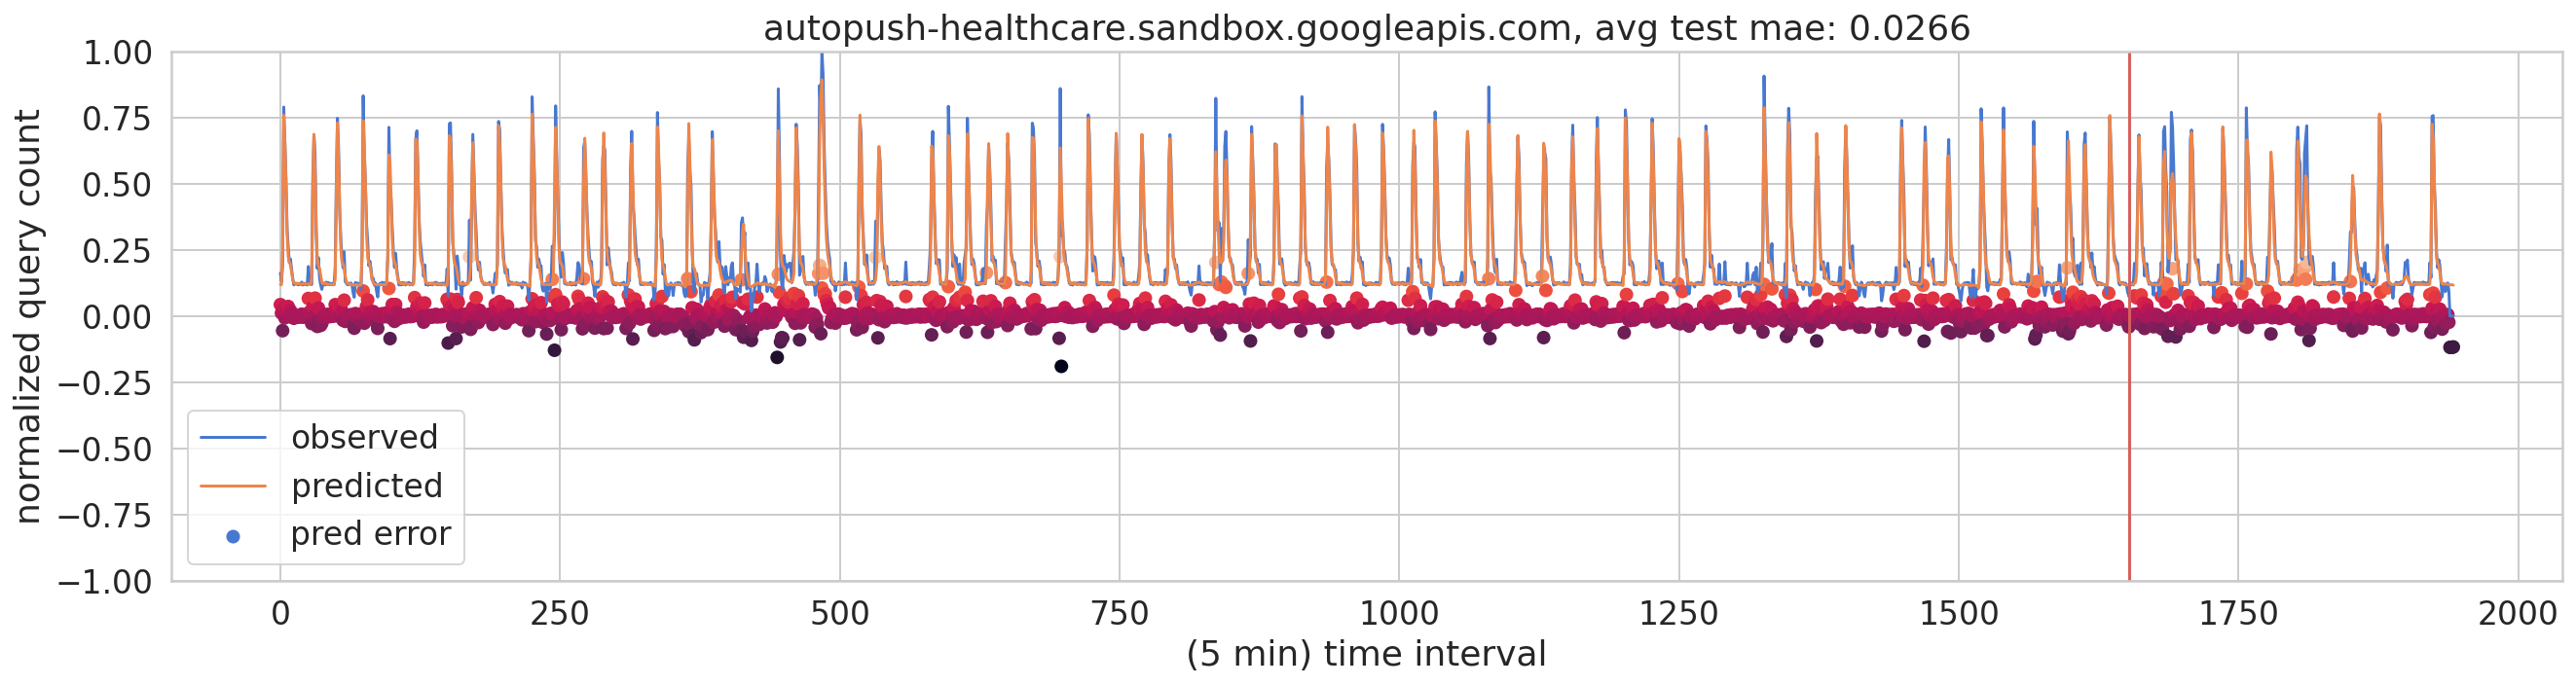

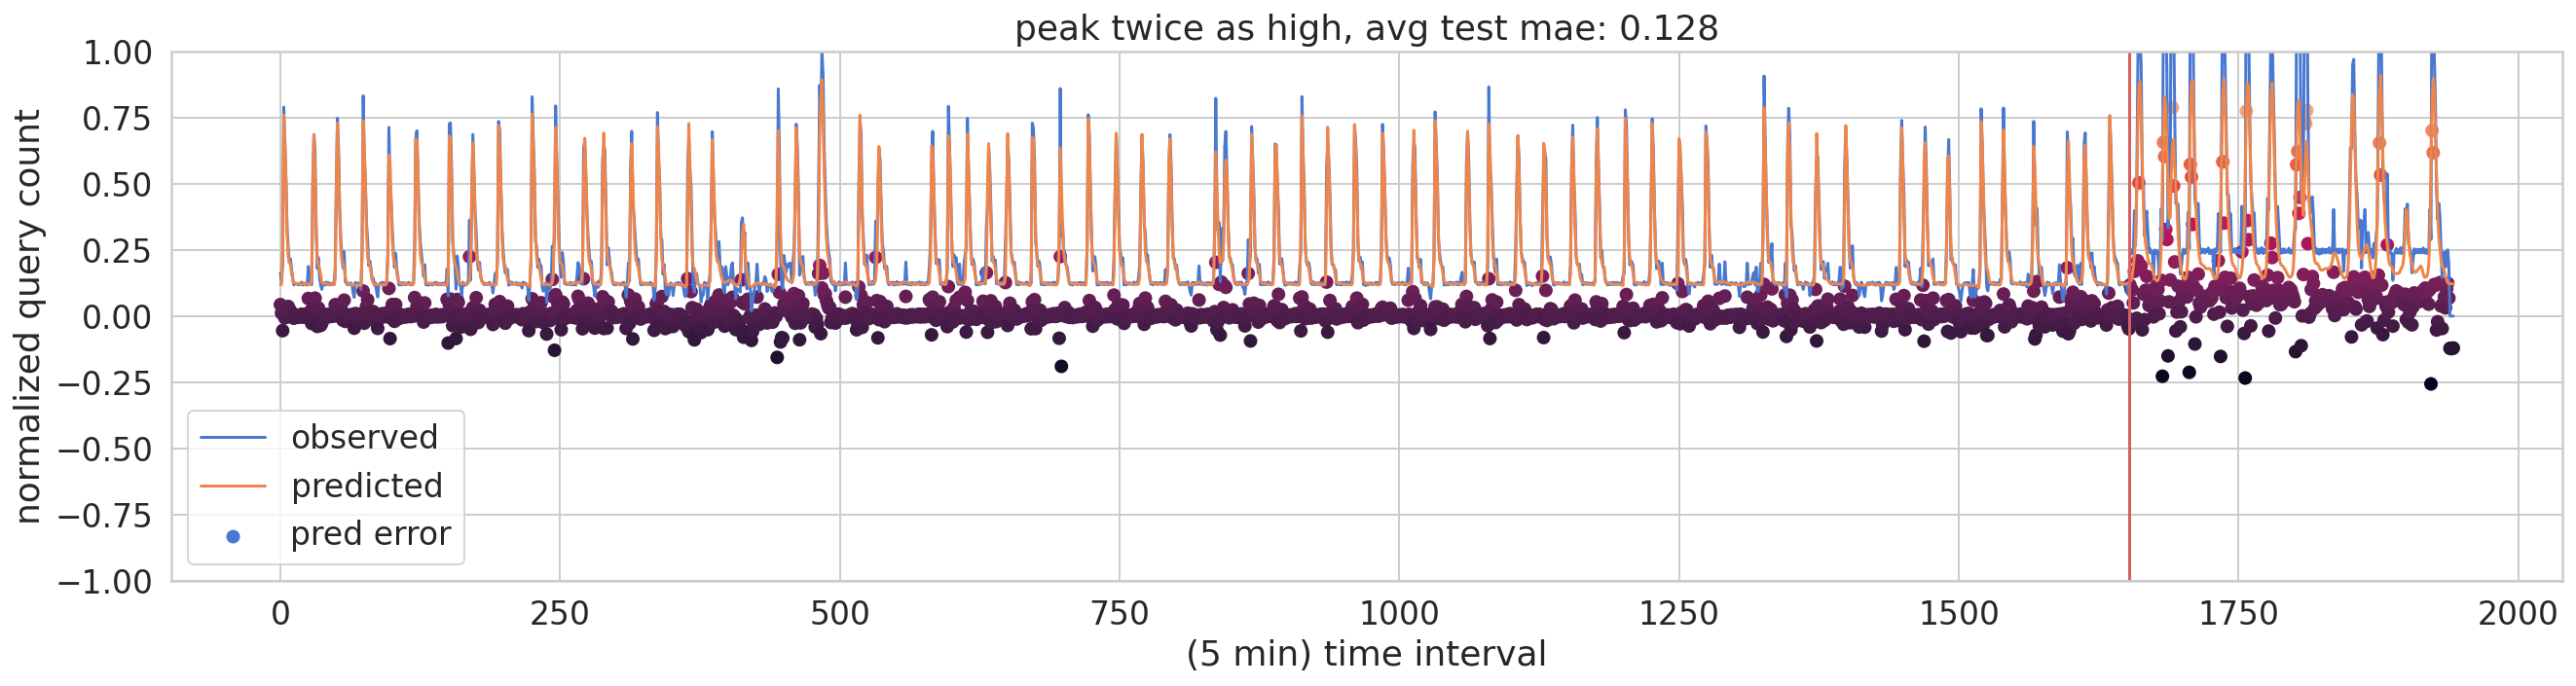

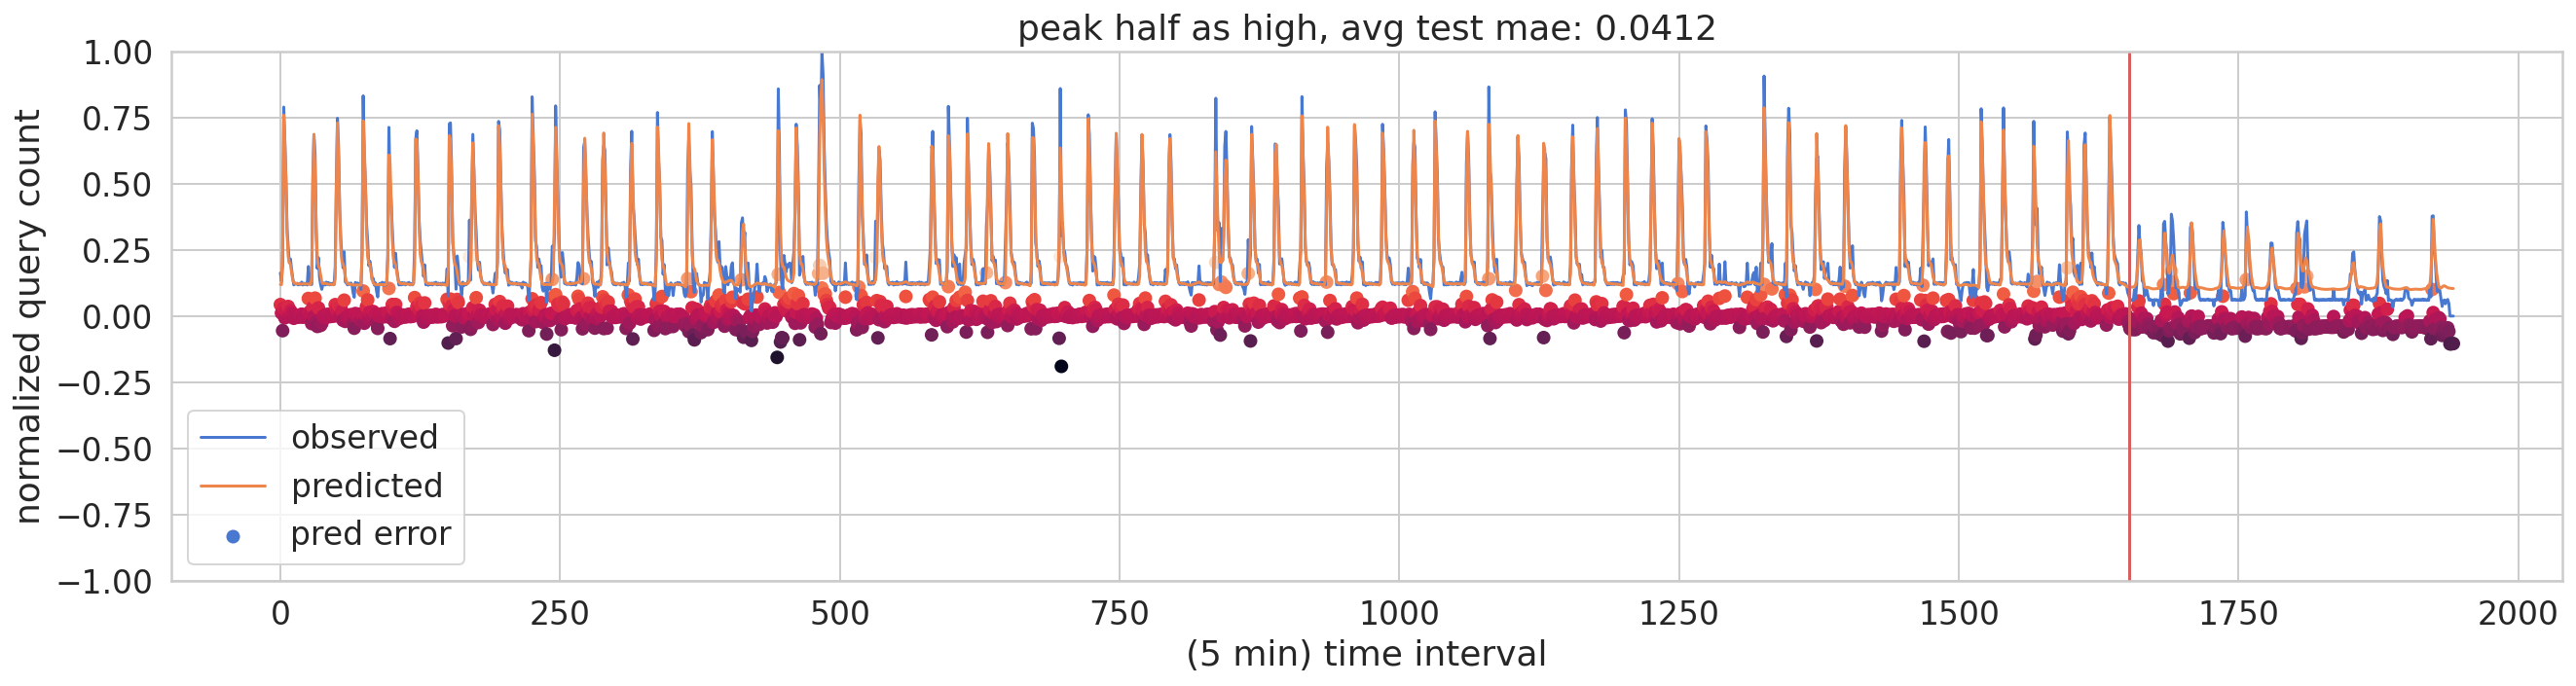

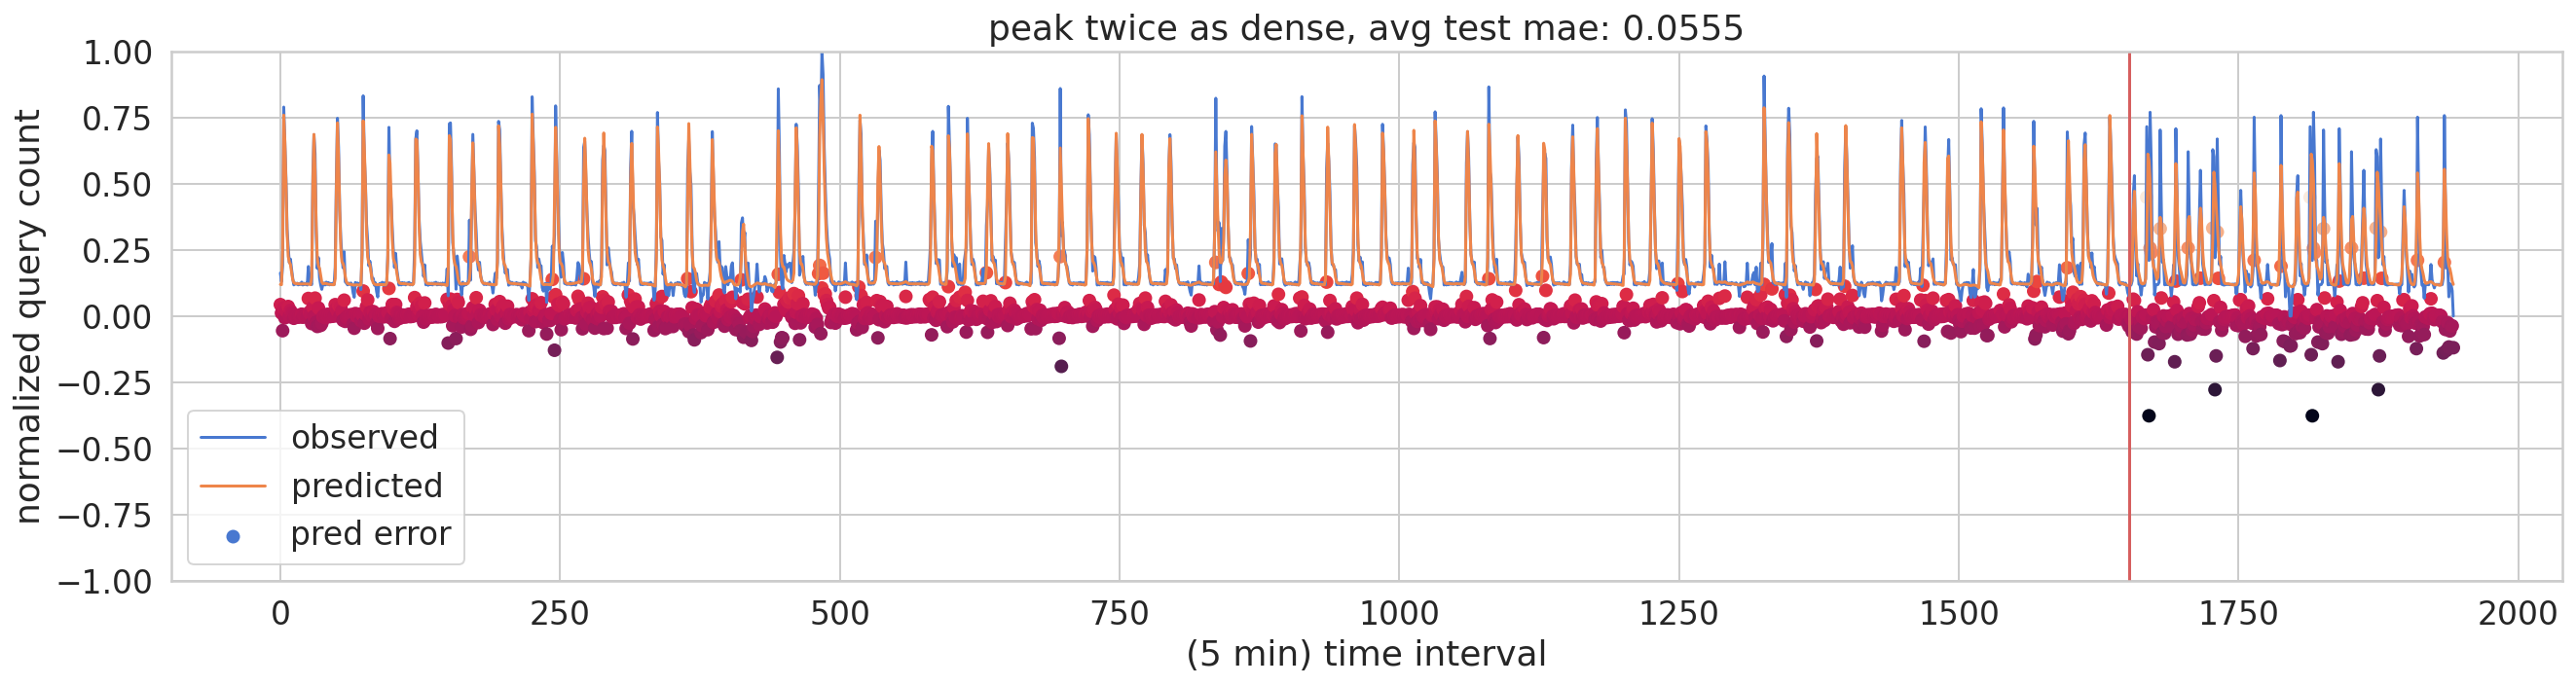

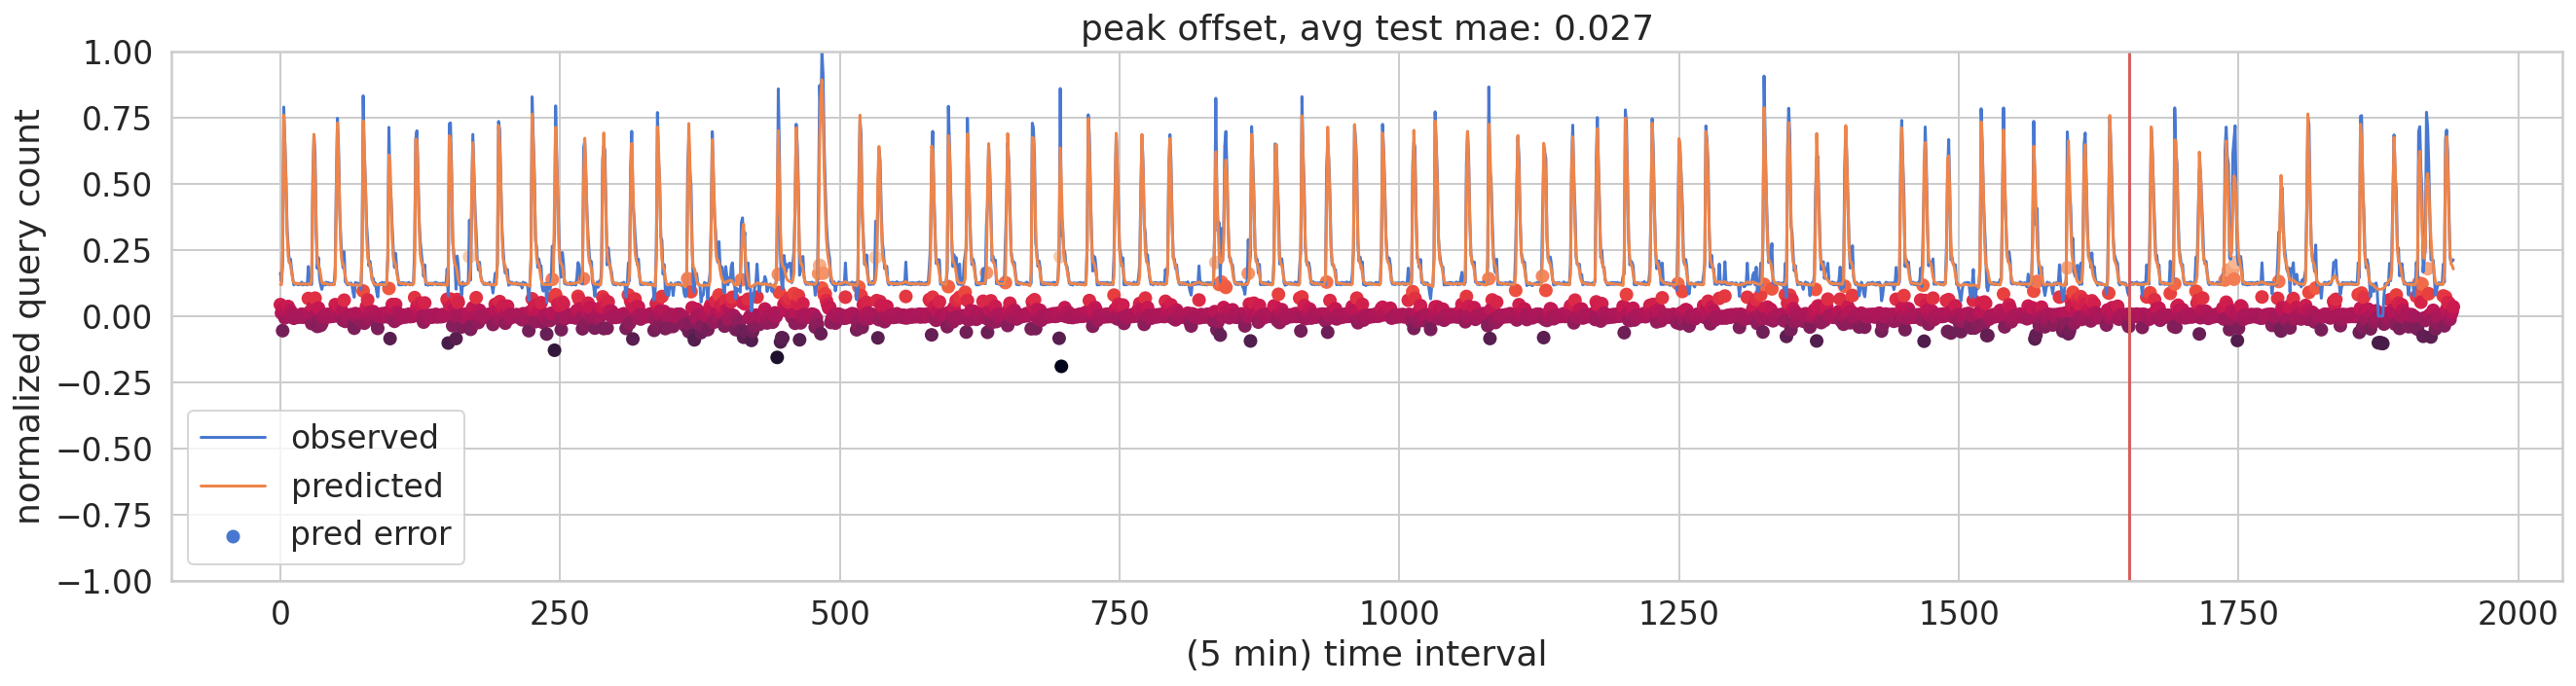

In [60]:
make_prediction(d,  'autopush-healthcare.sandbox.googleapis.com')
make_prediction(d1, 'peak twice as high')
make_prediction(d2, 'peak half as high')
make_prediction(d3, 'peak twice as dense')
make_prediction(d4, 'peak offset')